In [1]:
import tensorflow.keras as keras
from ray.tune import track
import numpy as np
np.random.seed(0)

import tensorflow as tf
print(tf.__version__)
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import ray
from ray import tune

import inspect
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline

'''
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        track.log(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))
    
'''   
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """
    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()
    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        if "acc" in logs:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs["acc"])
        else:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs.get("accuracy"))
            
def create_model(learning_rate, dense_1, dense_2):
    assert learning_rate > 0 and dense_1 > 0 and dense_2 > 0, "Did you set the right configuration?"
    model = Sequential()
    model.add(Dense(int(dense_1), input_shape=(43,), activation='relu', name='fc1'))
    model.add(Dense(int(dense_2), activation='relu', name='fc2'))
    model.add(Dense(10, activation='softmax', name='output'))
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
        
def tune_UNSW(config):  
    model = create_model(learning_rate=config["lr"], dense_1=config["dense_1"], dense_2=config["dense_2"])  # TODO: Change me.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    task_dataset = pickle.load(open('/root/Raytune-Continual-Learning-UNSW/task_dataset.pkl', "rb"))
    X_train = task_dataset[0]
    Y_train = task_dataset[1]
    X_test = task_dataset[2]
    Y_test = task_dataset[3]
    # Train the model
    hist = model.fit(
        X_train, Y_train, 
        validation_data=(X_test, Y_test),
        verbose=0, 
        batch_size=100, 
        epochs=15, 
        callbacks=callbacks)
    for key in hist.history:
        print(key)

# Random and uniform sampling for hypertune
def random_search(task_data):
    import numpy as np; np.random.seed(5)  
    hyperparameter_space = {
        "lr": tune.loguniform(0.001, 0.1),  
        "dense_1": tune.uniform(50, 150),
        "dense_2": tune.uniform(20, 100),
    }  
    num_samples = 15  
    ####################################################################################################
    ################ This is just a validation function for tutorial purposes only. ####################
    HP_KEYS = ["lr", "dense_1", "dense_2"]
    assert all(key in hyperparameter_space for key in HP_KEYS), (
        "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
    ######################################################################################################

    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False)
    # We clean out the logs before running for a clean visualization later.
    ! rm -rf ~/ray_results/tune_UNSW
    analysis = tune.run(
        tune_UNSW, 
        verbose=1, 
        config=hyperparameter_space,
        num_samples=num_samples)

    assert len(analysis.trials) > 2, "Did you set the correct number of samples?"

    # Obtain the directory where the best model is saved.
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          'lr:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['lr'], 'dense_1:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['dense_1'], 'dense_2:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['dense_2']        )
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5")
    tuned_model.summary()
    X_test = task_data[2]
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    return(analysis.get_best_config(metric='keras_info/val_acc', mode='max'))

#PBT population based sampling 
def mutation_pbtsearch(task_data, task_id=0):
    from ray.tune.schedulers import PopulationBasedTraining
    from ray.tune.utils import validate_save_restore
    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="mean_accuracy",
        mode="max",
        perturbation_interval=5,
        hyperparam_mutations={
            # distribution for resampling
            "lr": lambda: np.random.uniform(0.0001, 1),
            # allow perturbations within this set of categorical values
            "dense_1": [40, 60, 100], "dense_2": [30, 50, 70], 
        }
    )
    import os
    old_dirs = os.listdir('/root/ray_results/')

    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False)

    analysis = tune.run(
        tune_UNSW,
        name="PBT_UNSW"+ str(task_id),
        scheduler=scheduler,
        reuse_actors=True,
        verbose=1,
        stop={
            "training_iteration": 20,
        },
        num_samples=10,

        # PBT starts by training many neural networks in parallel with random hyperparameters. 
        config={
            "lr": tune.uniform(0.001, 1),
            "dense_1": tune.uniform(50, 150), "dense_2": tune.uniform(20, 100),
        })
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          analysis.get_best_config(metric='keras_info/val_acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5")
    tuned_model.summary()
    X_test = task_data[2]
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    return(analysis.get_best_config(metric='keras_info/val_acc', mode='max'))

#ASHA Schedular
def ASHA_search(task_data):
    from ray.tune.schedulers import ASHAScheduler
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False)
    custom_scheduler = ASHAScheduler(
        metric='mean_accuracy',
        mode="max",
        reduction_factor = 2,
        grace_period=1)# TODO: Add a ASHA as custom scheduler here
    hyperparameter_space={
        "lr": tune.uniform(0.001, 1),
            "dense_1": tune.uniform(50, 150), "dense_2": tune.uniform(20, 100),
        }
    
    analysis = tune.run(
        tune_UNSW, 
        scheduler=custom_scheduler, 
        config=hyperparameter_space, 
        verbose=1,
        num_samples=10,
        #resources_per_trial={"cpu":4},
        name="ASHA_UNSW"  # This is used to specify the logging directory.
    )
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          analysis.get_best_config(metric='keras_info/val_acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5")
    tuned_model.summary()
    X_test = task_data[2]
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    return(analysis.get_best_config(metric='keras_info/val_acc', mode='max'))


#HyperOpt Search 
def hyperopt_search(task_data):
    from hyperopt import hp
    from ray.tune.suggest.hyperopt import HyperOptSearch

    # This is a HyperOpt specific hyperparameter space configuration.
    space = {
            "lr": hp.loguniform("lr", -10, -1),
            "dense_1": hp.loguniform("dense_1", 0.3, 3), "dense_2": hp.loguniform("dense_2", 0.2, 2),
        }
    # Create a HyperOptSearch object by passing in a HyperOpt specific search space.
    # Also enforce that only 1 trials can run concurrently.
    hyperopt_search = HyperOptSearch(space, max_concurrent=1, metric="mean_loss", mode="min") 

    # We Remove the dir so that we can visualize tensorboard correctly
    ! rm -rf ~/ray_results/search_algorithm 
    
    analysis = tune.run(
        tune_UNSW, 
        num_samples=10,  
        search_alg=hyperopt_search,
        verbose=1,
        name="UNSW_search_algorithm",
    )
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          analysis.get_best_config(metric='keras_info/val_acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5")
    tuned_model.summary()
    X_test = task_data[2]
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    return(analysis.get_best_config(metric='keras_info/val_acc', mode='max'))

#Bayesian Search
#https://docs.ray.io/en/latest/tune-searchalg.html#bohb
#https://github.com/ray-project/ray/blob/master/python/ray/tune/examples/bohb_example.py
#https://github.com/ray-project/ray/blob/master/python/ray/tune/suggest/bohb.py
def Bayesian_search(task_data):
    from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
    from ray.tune.suggest.bohb import TuneBOHB
    import ConfigSpace as CS
    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("lr", lower=0.001, upper=0.1))
    config_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("dense_1", lower=50, upper=150))
    config_space.add_hyperparameter(
        CS.UniformFloatHyperparameter("dense_2", lower=20, upper=100))
    
    bohb_hyperband = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=2,
        metric='mean_accuracy', 
        mode='max')
    bohb_search = TuneBOHB(
        config_space, max_concurrent=2, metric='mean_accuracy', 
        mode='max')
    
    tune.run(tune_UNSW,
        name="Bayseian_UNSW",
        scheduler=bohb_hyperband,
        search_alg=bohb_search,
        num_samples=10,
        stop={"training_iteration": 50})
    from ray.tune import Analysis as analysis
    analysis = ray.tune.Analysis('/root/ray_results/Bayseian_UNSW') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5")
    tuned_model.summary()
    X_test = task_data[2]
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

1.14.0


In [2]:
print(ray.__version__)

1.0.1.post1


In [33]:
import pickle
import pdb
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            layer_weights[0][:last_model_stats['weights'][-1][2*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][2*i]
            layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][2*i+1]
            model.layers[i].set_weights(layer_weights)      

    def on_batch_end(self, batch, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            #pdb.set_trace()
            layer_weights[0][:last_model_stats['weights'][-1][2*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][2*i]
            layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][2*i+1]
            model.layers[i].set_weights(layer_weights)
        
def create_task(data_path):
    data = pickle.load(open(data_path, "rb"))
    return data

task_list = create_task('./data/unsw_tasks.pkl')
num_tasks=5
Model_Perf_save = {}
Model_Perf_save['acc'] = []
Model_Perf_save['shape'] = []
Model_Perf_save['weights'] = []
for task_id in range(num_tasks-1, -1, -1):
    !rm -rf task_dataset.pkl
    f = open('task_dataset.pkl', 'wb')
    pickle.dump(task_list[task_id], f)
    f.close()
    #hyper_param = random_search(task_list[task_id])
    hyper_param = mutation_pbtsearch(task_list[task_id], task_id)
    if task_id == 4:
        model = create_model(learning_rate=0.01, dense_1=hyper_param["dense_1"], dense_2=hyper_param["dense_2"])
        #call one of the search algorithm
        history = model.fit(task_list[task_id][0], task_list[task_id][1],
              batch_size=128, epochs=10, verbose=0,
              validation_data=(task_list[task_id][2], task_list[task_id][3]))
    else:
        dense_1 = hyper_param["dense_1"] + Model_Perf_save['shape'][-1][1][0]
        dense_2 = hyper_param["dense_2"] + Model_Perf_save['shape'][-1][3][0]
        model = create_model(learning_rate=0.01, dense_1=dense_1, dense_2=dense_2)
        history = model.fit(task_list[task_id][0], task_list[task_id][1],
              batch_size=128, epochs=10, verbose=0,
              validation_data=(task_list[task_id][2], task_list[task_id][3]), callbacks  = [LossHistory()])
    loss_and_metrics = model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=2)
    Model_Perf_save['acc'].append(loss_and_metrics[1])
    Model_Perf_save['shape'].append([i.shape for i in model.get_weights()])
    Model_Perf_save['weights'].append(model.get_weights()) 

Trial name,status,loc,dense_1,dense_2,lr,acc,iter,total time (s),ts,val_loss
tune_UNSW_cebc5_00000,TERMINATED,,53.1005,85.4074,0.217606,0.58254,15,6.32212,0,1.07758
tune_UNSW_cebc5_00001,TERMINATED,,58.4256,22.1152,0.430372,0.521429,15,6.3417,0,0.701072
tune_UNSW_cebc5_00002,TERMINATED,,40,70,0.0562989,0.588889,15,6.92061,0,2.16133
tune_UNSW_cebc5_00003,TERMINATED,,60,30,1.17368,0.489683,15,6.0608,0,0.706652
tune_UNSW_cebc5_00004,TERMINATED,,100,70,0.0562989,0.610317,15,6.66163,0,1.56584
tune_UNSW_cebc5_00005,TERMINATED,,100,50,0.0450391,0.579365,15,6.72918,0,2.17259
tune_UNSW_cebc5_00006,TERMINATED,,86.3798,67.8185,0.978066,0.523016,15,6.0146,0,0.697779
tune_UNSW_cebc5_00007,TERMINATED,,60.0017,84.4549,0.0469157,0.578571,15,6.71283,0,2.2643
tune_UNSW_cebc5_00008,TERMINATED,,59.275,76.445,0.808754,0.529365,15,6.13509,0,0.710395
tune_UNSW_cebc5_00009,TERMINATED,,40,70,0.996267,0.511905,15,6.47286,0,0.710153


2021-04-29 13:00:21,755	INFO tune.py:439 -- Total run time: 20.85 seconds (20.82 seconds for the tuning loop).


You can use any of the following columns to get the best model: 
['keras_info/loss', 'keras_info/acc', 'keras_info/val_loss', 'keras_info/val_acc'].
Best model: tune_UNSW_cebc5_00003 {'lr': 1.1736790925457892, 'dense_1': 60, 'dense_2': 30}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 60)                2640      
_________________________________________________________________
fc2 (Dense)                  (None, 30)                1830      
_________________________________________________________________
output (Dense)               (None, 10)                310       
Total params: 4,780
Trainable params: 4,780
Non-trainable params: 0
_________________________________________________________________
Loss is 0.7080
Tuned accuracy is 0.5339
3746/3746 - 0s - loss: 0.7397 - acc: 0.5174


In [34]:
print('Accuracy for tasks:',Model_Perf_save['acc'])
print('------------------------')
print('Nodes in hidden layer (1,2): ',[(i[0][1],i[2][1])for i in Model_Perf_save['shape']])

Accuracy for tasks: [0.9018211, 0.9176129, 0.9766774, 0.72183895, 0.51735187]
------------------------
Nodes in hidden layer (1,2):  [(40, 30), (140, 80), (240, 110), (300, 140), (360, 170)]


Best config:{'dense_1': 81.11437745591928, 'dense_2': 69.9504346282319, 'lr': 0.013226168161356931}


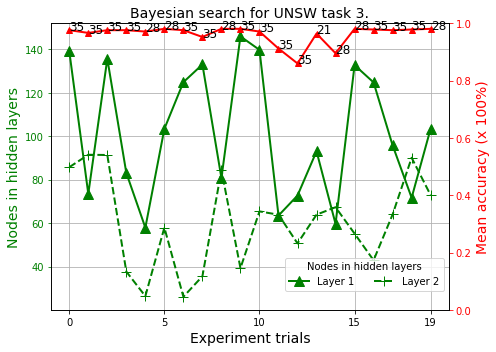

In [5]:
#For Bayesian:
import matplotlib
progress_file = {}
ray_results_path='/root/ray_results/Bayseian_UNSW/'
from ray.tune import Analysis as analysis
analysis = ray.tune.Analysis(ray_results_path) 
print('Best config:'+str(analysis.get_best_config(metric='keras_info/acc', mode='max')))
analysis_dataframe = analysis.dataframe().sort_values(by=['date'])[['training_iteration', 'config/dense_1', 'config/dense_2', 'mean_accuracy']]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(7,5))
xs = range(0,len(analysis_dataframe))

ax1.plot(xs[:20],analysis_dataframe['config/dense_1'][:20],'g^-', markersize=10, linewidth=2, label='Layer 1')
ax1.plot(xs[:20],analysis_dataframe['config/dense_2'][:20],'g+--', markersize=10, linewidth=2, label='Layer 2')
ax1.set_xlabel('Experiment trials', fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Nodes in hidden layers', color='g', fontsize=14)
ax1.tick_params('y', colors='g')
ax1.set_xticks([0,5, 10, 15, 19])
ax1.legend(bbox_to_anchor=(1.0, 0.20), loc='upper right', title='Nodes in hidden layers', ncol=2) 
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(xs[:20],analysis_dataframe['mean_accuracy'][:20],'r^-', linewidth=2)
for i,j in zip(xs[:20],analysis_dataframe['mean_accuracy'][:20]):
    ax2.annotate(analysis_dataframe['training_iteration'][i],xy=(i,j), fontsize=12)
ax2.set_ylabel('Mean accuracy (x 100%)', color='r', fontsize=14)
ax2.tick_params('y', colors='r')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title('Bayesian search for UNSW task 3.', fontsize=14)
fig.tight_layout()
plt.savefig('Bayesian_UNSW.pdf')
plt.show()

-------Trial:  cebc5_00005 ----
Started with nodes in L1= 109 , nodes in L2= 76
Perturbed at current back-prop iteration: 5 . Nodes in L1= 40 . Nodes in L2= 30
Perturbed at current back-prop iteration: 15 . Nodes in L1= 100 . Nodes in L2= 50


-------Trial:  cebc5_00001 ----
Started with nodes in L1= 58 , nodes in L2= 22


-------Trial:  cebc5_00009 ----
Started with nodes in L1= 81 , nodes in L2= 87
Perturbed at current back-prop iteration: 5 . Nodes in L1= 100 . Nodes in L2= 70
Perturbed at current back-prop iteration: 15 . Nodes in L1= 40 . Nodes in L2= 70


-------Trial:  cebc5_00007 ----
Started with nodes in L1= 60 , nodes in L2= 84


-------Trial:  cebc5_00003 ----
Started with nodes in L1= 121 , nodes in L2= 57
Perturbed at current back-prop iteration: 5 . Nodes in L1= 40 . Nodes in L2= 50
Perturbed at current back-prop iteration: 15 . Nodes in L1= 60 . Nodes in L2= 30


-------Trial:  cebc5_00008 ----
Started with nodes in L1= 59 , nodes in L2= 76


-------Trial:  cebc5_00004 

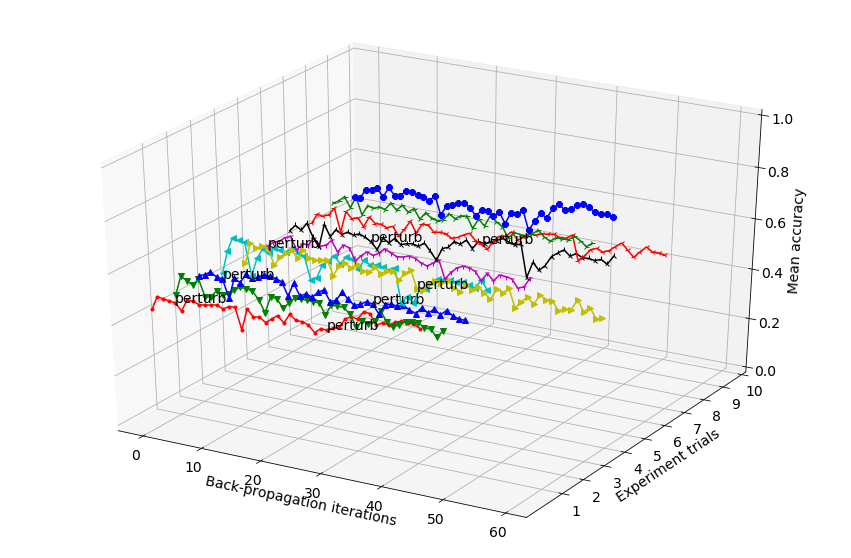

-------Trial:  7b5c8_00002 ----
Started with nodes in L1= 131 , nodes in L2= 80
Perturbed at current back-prop iteration: 10 . Nodes in L1= 100 . Nodes in L2= 30
Perturbed at current back-prop iteration: 10 . Nodes in L1= 60 . Nodes in L2= 30


-------Trial:  7b5c8_00009 ----
Started with nodes in L1= 70 , nodes in L2= 48


-------Trial:  7b5c8_00005 ----
Started with nodes in L1= 96 , nodes in L2= 42
Perturbed at current back-prop iteration: 15 . Nodes in L1= 60 . Nodes in L2= 70


-------Trial:  7b5c8_00004 ----
Started with nodes in L1= 82 , nodes in L2= 43
Perturbed at current back-prop iteration: 5 . Nodes in L1= 100 . Nodes in L2= 30
Perturbed at current back-prop iteration: 15 . Nodes in L1= 100 . Nodes in L2= 70
Perturbed at current back-prop iteration: 15 . Nodes in L1= 100 . Nodes in L2= 50


-------Trial:  7b5c8_00008 ----
Started with nodes in L1= 74 , nodes in L2= 85


-------Trial:  7b5c8_00000 ----
Started with nodes in L1= 70 , nodes in L2= 34
Perturbed at current back-

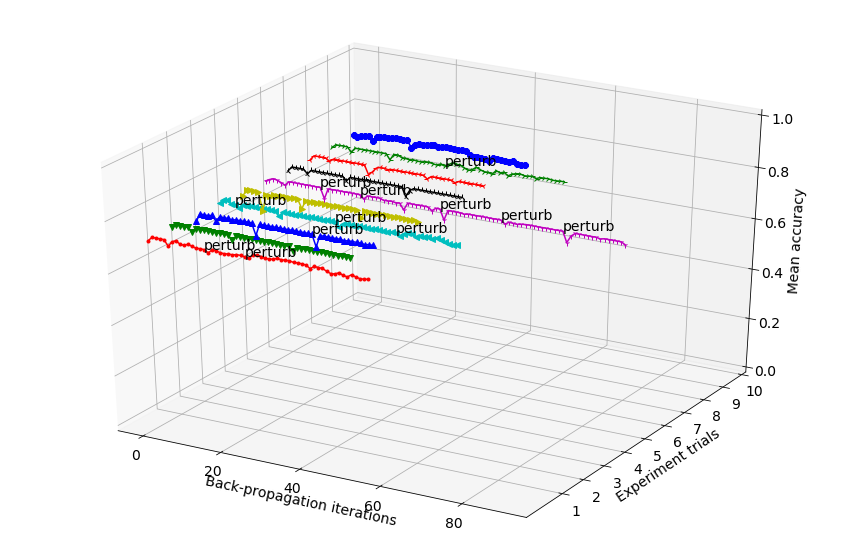

-------Trial:  0cb7f_00001 ----
Started with nodes in L1= 66 , nodes in L2= 92
Perturbed at current back-prop iteration: 10 . Nodes in L1= 60 . Nodes in L2= 50


-------Trial:  0cb7f_00003 ----
Started with nodes in L1= 64 , nodes in L2= 99
Perturbed at current back-prop iteration: 10 . Nodes in L1= 40 . Nodes in L2= 30
Perturbed at current back-prop iteration: 15 . Nodes in L1= 100 . Nodes in L2= 30


-------Trial:  0cb7f_00002 ----
Started with nodes in L1= 81 , nodes in L2= 86
Perturbed at current back-prop iteration: 10 . Nodes in L1= 40 . Nodes in L2= 30
Perturbed at current back-prop iteration: 10 . Nodes in L1= 60 . Nodes in L2= 30
Perturbed at current back-prop iteration: 15 . Nodes in L1= 60 . Nodes in L2= 50




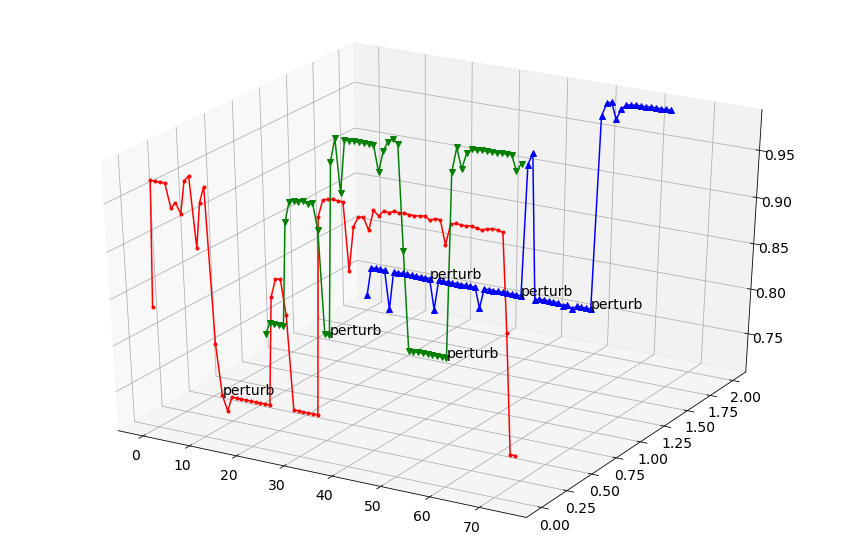

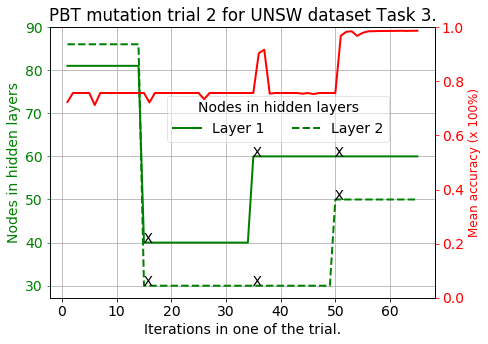

-------Trial:  0cb7f_00008 ----
Started with nodes in L1= 58 , nodes in L2= 81
Perturbed at current back-prop iteration: 10 . Nodes in L1= 100 . Nodes in L2= 50


-------Trial:  0cb7f_00004 ----
Started with nodes in L1= 144 , nodes in L2= 81


-------Trial:  0cb7f_00006 ----
Started with nodes in L1= 113 , nodes in L2= 87


-------Trial:  0cb7f_00005 ----
Started with nodes in L1= 132 , nodes in L2= 31
Perturbed at current back-prop iteration: 15 . Nodes in L1= 40 . Nodes in L2= 70
Perturbed at current back-prop iteration: 15 . Nodes in L1= 100 . Nodes in L2= 50


-------Trial:  0cb7f_00007 ----
Started with nodes in L1= 111 , nodes in L2= 71


-------Trial:  0cb7f_00009 ----
Started with nodes in L1= 120 , nodes in L2= 88


-------Trial:  0cb7f_00000 ----
Started with nodes in L1= 148 , nodes in L2= 26


-------Trial:  89abd_00000 ----
Started with nodes in L1= 97 , nodes in L2= 40


-------Trial:  89abd_00002 ----
Started with nodes in L1= 118 , nodes in L2= 46
Perturbed at current 

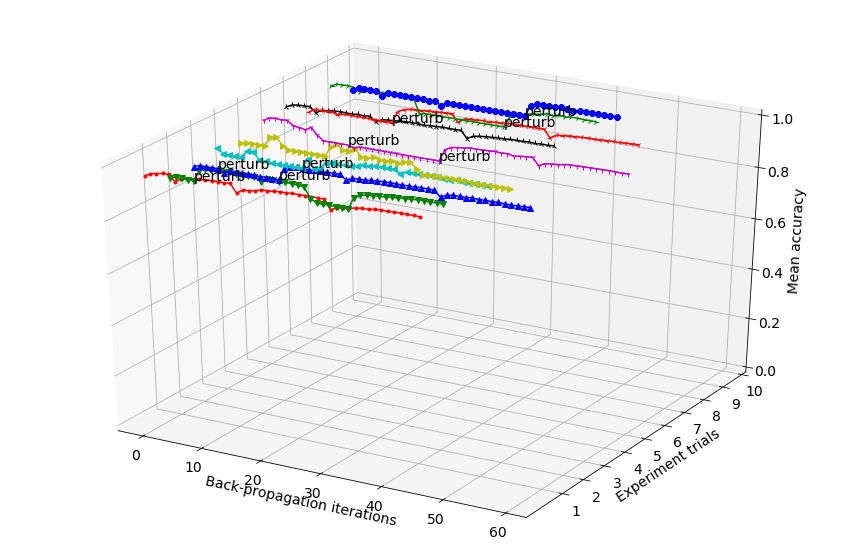

-------Trial:  7a3da_00002 ----
Started with nodes in L1= 139 , nodes in L2= 97
Perturbed at current back-prop iteration: 15 . Nodes in L1= 40 . Nodes in L2= 70
Perturbed at current back-prop iteration: 15 . Nodes in L1= 40 . Nodes in L2= 30


-------Trial:  7a3da_00000 ----
Started with nodes in L1= 121 , nodes in L2= 68
Perturbed at current back-prop iteration: 10 . Nodes in L1= 100 . Nodes in L2= 70


-------Trial:  7a3da_00004 ----
Started with nodes in L1= 142 , nodes in L2= 25


-------Trial:  7a3da_00001 ----
Started with nodes in L1= 92 , nodes in L2= 71
Perturbed at current back-prop iteration: 10 . Nodes in L1= 100 . Nodes in L2= 70
Perturbed at current back-prop iteration: 10 . Nodes in L1= 40 . Nodes in L2= 50


-------Trial:  7a3da_00007 ----
Started with nodes in L1= 96 , nodes in L2= 82
Perturbed at current back-prop iteration: 5 . Nodes in L1= 100 . Nodes in L2= 50


-------Trial:  7a3da_00003 ----
Started with nodes in L1= 129 , nodes in L2= 62


-------Trial:  7a3da_0

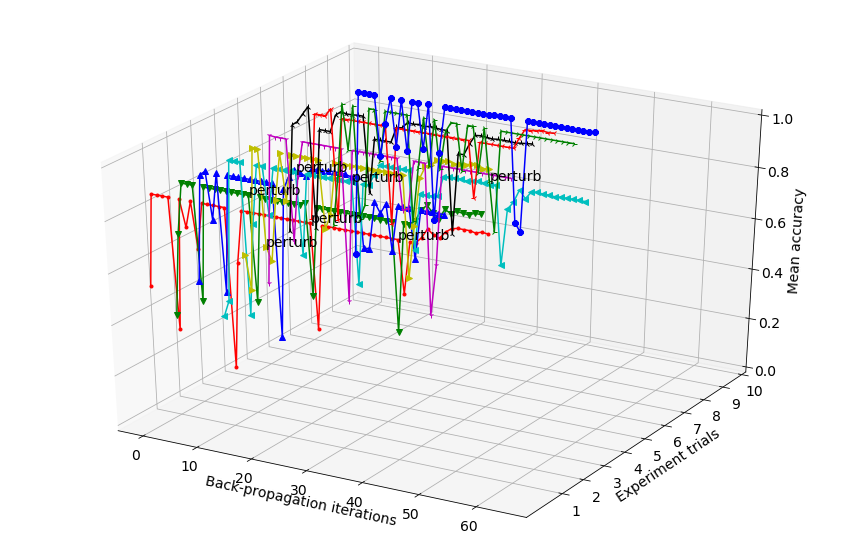

In [24]:
#PBT
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import pandas as pd
import os
for task_id in range(5):
    progress_file = {}
    ray_results_path='/root/ray_results/PBT_UNSW'+str(task_id)+'/'
    folders = os.listdir(ray_results_path)
    for folder in folders:
        try:
            raw = folder.split('=')
            dense_1 = int(float(raw[1].split(',')[0]))
            dense_2 = int(float(raw[2].split(',')[0]))
            progress_file[str(dense_1) + ',' + str(dense_2)] = pd.read_csv(ray_results_path+folder+'/progress.csv')
        except:
            pass
    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')

    color_map=['r', 'g', 'b', 'c', 'y', 'm', 'k', 'r', 'g', 'b', 'r', 'g', 'b', 'c', 'y', 'm', 'k', 'r', 'g', 'b', 'r', 'g', 'b', 'c', 'y', 'm', 'k', 'r', 'g', 'b']
    label_map = list(progress_file.keys())
    
    marker_map = [".", "v", "^", "<", ">", "1", "2", "3", "4", "8", ".", "v", "^", "<", ">", "1", "2", "3", "4", "8", ".", "v", "^", "<", ">", "1", "2", "3", "4", "8"]

    for counter,key in enumerate(progress_file.keys()):
        xs = range(len(progress_file[key]))
        ys = [counter]*len(progress_file[key])
        zs = progress_file[key]['mean_accuracy'].tolist()
        ax.plot(xs, ys, zs, c=color_map[counter], marker=marker_map[counter], label = label_map[counter])
        config_dense_1 = []
        config_dense_2 = []
        perturbation_location = []
        current_val_dense1 = None
        current_val_dense2 = None
        curr_dense1 = None
        curr_dense2 = None
        print('-------Trial: ', progress_file[key]['trial_id'][0],'----')
        for index,back_prop_iter in enumerate(progress_file[key]['experiment_tag']):
            if current_val_dense1 == None:
                current_val_dense1 = int(float(back_prop_iter.split(',')[0].split('=')[1]))
                current_val_dense2 = int(float(back_prop_iter.split(',')[1].split('=')[1]))
                print('Started with nodes in L1=', current_val_dense1, ', nodes in L2=', current_val_dense2)
            elif 'perturbed' in back_prop_iter:
                curr_dense1 = int(back_prop_iter.split('perturbed')[1].split(',')[0].split('=')[1]) 
                curr_dense2 = int(back_prop_iter.split('perturbed')[1].split(',')[1].split('=')[1])
                if current_val_dense1 != curr_dense1 or current_val_dense2 != curr_dense2:
                    current_val_dense1 = curr_dense1
                    current_val_dense2 = curr_dense2
                    print('Perturbed at current back-prop iteration:', progress_file[key]['training_iteration'][index], '. Nodes in L1=', current_val_dense1, '. Nodes in L2=', current_val_dense2)
                    ax.text(index, counter, zs[index], 'perturb')
                    perturbation_location.append(index)
            config_dense_1.append(current_val_dense1)
            config_dense_2.append(current_val_dense2)
        print('\n')
        import pdb
        if key=='81,86':
            #For mutation, focusing on one trail to show mutation
            analysis_dataframe = progress_file['81,86']
            task_id=1
            import matplotlib.pyplot as plt

            fig, ax1 = plt.subplots(figsize=(7,5))
            xs = range(1,len(analysis_dataframe)+1)
            ax1.plot(xs,config_dense_1,'g-', markersize=10, linewidth=2, label='Layer 1')
            ax1.plot(xs,config_dense_2,'g--', markersize=10, linewidth=2, label='Layer 2')
            ax1.set_yticks([30,40,50,60,70,80,90])
            ax1.set_xlabel('Iterations in one of the trial.')
            # Make the y-axis label, ticks and tick labels match the line color.
            ax1.set_ylabel('Nodes in hidden layers', color='g')
            ax1.tick_params('y', colors='g')
            #ax1.set_xticks([1, 100, 200, 300, 400, 500, 600, 700])
            for i in perturbation_location:
                if i != 299:
                    ax1.annotate(' X', xy=(i, config_dense_1[i]), fontsize=14)
            for i in perturbation_location:
                if i != 159:
                    if i != 379:
                        ax1.annotate(' X', xy=(i, config_dense_2[i]), fontsize=14)
            ax1.legend(loc='lower right', title='Nodes in hidden layers', bbox_to_anchor=[0.9, 0.55], fancybox=True, ncol=2, framealpha=0.5)
            plt.grid(True)

            ax2 = ax1.twinx()
            ax2.plot(xs,analysis_dataframe['mean_accuracy'],'r-', linewidth=2)
            ax2.set_ylabel('Mean accuracy (x 100%)', color='r', fontsize=12)
            ax2.tick_params('y', colors='r')
            ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            plt.title('PBT mutation trial 2 for UNSW dataset Task 3.')
            fig.tight_layout()
            plt.savefig('UNSW_PBT_Task'+str(task_id+1)+'.pdf')
            plt.show()
    ax.set_xlabel('Back-propagation iterations')
    ax.set_ylabel('Experiment trials')
    ax.set_zlabel('Mean accuracy')
    ax.set_yticks(range(1,len(progress_file)+1))
    ax.set_zticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.legend(bbox_to_anchor=(1.20, 0.8), loc='upper right', title='(dense_1,dense_2)')
    import ray
    from ray.tune import Analysis as analysis
    analysis = ray.tune.Analysis(ray_results_path) 
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    #plt.title('Task:'+str(task_id+1)+'. Best trial:'+logdir.split('tune_ASNM')[1].split('_')[2]+str(analysis.get_best_config(metric='keras_info/acc', mode='max')))
    plt.show()    

In [5]:
#Verification that trained weights are constant between tasks.
for i in range(num_tasks-1):
    curr_task_layer_weights = Model_Perf_save['weights'][i].copy()
    next_task_layer_weights = Model_Perf_save['weights'][i+1].copy()
    for j in range(len(curr_task_layer_weights)):
        if curr_task_layer_weights[j].ndim == 1:
            truncated_weights_array = np.resize(next_task_layer_weights[j], curr_task_layer_weights[j].shape)
        else:
            truncated_weights_array = next_task_layer_weights[j][:curr_task_layer_weights[j].shape[0],:curr_task_layer_weights[j].shape[1]]
        print('-----Task {} and {}----weight matrix {}:'.format(i+1,i+2,j+1))
        subtract_matrix = curr_task_layer_weights[j] - truncated_weights_array
        print( '# of non-zero elements {} out of {}.'.format(np.count_nonzero(subtract_matrix), subtract_matrix.size))          

-----Task 1 and 2----weight matrix 1:
# of non-zero elements 0 out of 5805.
-----Task 1 and 2----weight matrix 2:
# of non-zero elements 0 out of 135.
-----Task 1 and 2----weight matrix 3:
# of non-zero elements 0 out of 3510.
-----Task 1 and 2----weight matrix 4:
# of non-zero elements 0 out of 26.
-----Task 1 and 2----weight matrix 5:
# of non-zero elements 0 out of 260.
-----Task 1 and 2----weight matrix 6:
# of non-zero elements 0 out of 10.
-----Task 2 and 3----weight matrix 1:
# of non-zero elements 0 out of 11610.
-----Task 2 and 3----weight matrix 2:
# of non-zero elements 0 out of 270.
-----Task 2 and 3----weight matrix 3:
# of non-zero elements 0 out of 14040.
-----Task 2 and 3----weight matrix 4:
# of non-zero elements 0 out of 52.
-----Task 2 and 3----weight matrix 5:
# of non-zero elements 0 out of 520.
-----Task 2 and 3----weight matrix 6:
# of non-zero elements 0 out of 10.
-----Task 3 and 4----weight matrix 1:
# of non-zero elements 0 out of 17415.
-----Task 3 and 4----